<center><font size=5><b>Extracting harmonics of $\phi$-dependent data in Gepard</b></font></center>

# Intro

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import gdevel as g
print(g.__version__)

0.9.11


In [4]:
# This just gets my current git revision hash, in case version number above is not reliable.
# You should comment this cell out if your Gepard installation is not git cloned from github repository.
import os
import subprocess
branch = subprocess.check_output(['git', '-C', os.path.dirname(g.__file__),
                                  'branch', '--show-current']).decode('ascii').strip()
revhash = subprocess.check_output(['git', '-C', os.path.dirname(g.__file__),
                                   'rev-parse', 'HEAD']).decode('ascii').strip()
print('Current git branch is "{}" and revision hash is {}'.format(branch, revhash))

Current git branch is "devel" and revision hash is 6a29f18c7246e4172fd8540814631d1b4fdb0f4a


In [5]:
def plotpts(bin1, bin2=None, replica=None):
    """Plot points in bin with errorbars."""
    fig, ax = plt.subplots(1,1, figsize=[6,6])
    ax.errorbar(bin1.phi.values, bin1.val.values, bin1.err.values, color='blue', linestyle='None',
               capsize=3)
    if isinstance(bin2, pd.DataFrame):
        ax.errorbar(bin2.phi.values, bin2.val.values, bin2.err.values, color='red', linestyle='None',
                   capsize=2)
    if isinstance(replica, np.ndarray):
        ax.plot(bin1.phi.values, replica, marker='o', color='red', linestyle='None')
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-np.pi, np.pi)
    fig.savefig('fig')

In [6]:
def plotFT(dfs, cosmax, sinmax):
    """Plot harmonics with with errorbars."""
    CM = cosmax
    SM = sinmax
    fig, ax = plt.subplots(1,1, figsize=[6,6])
    shift = 0
    for df in dfs:
        c = df.val.values[:CM+1]
        delc = df.err.values[:CM+1]
        s = df.val.values[CM+1:CM+SM+1]
        dels = df.err.values[CM+1:CM+SM+1]
        ax.errorbar(np.arange(CM+1)+shift, c, delc, linestyle='None', capsize=3,color='blue')
        ax.errorbar(np.arange(-1,-SM-1,-1)+shift, s, dels, linestyle='None', capsize=3, color='red')
        shift += 0.05
    ax.axhline(linestyle='-.', color='green', linewidth=0.5)
    ax.axvline(linestyle='-.', color='green', linewidth=0.5)
    #ax.legend(loc=4, fontsize=14).draw_frame(1)
    fig.savefig('fig')

# Basic extraction of harmonics (CLAS $A_{\rm LU}$)

In [7]:
g.describe_data(g.dset[91])

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
166 x ALU     CLAS    N/A    91  arXiv:1501.07052
----------------------------------------------
TOTAL = 166


We transform Gepard dataset into Pandas dataframe and take just some relevant columns.

In [8]:
dfALU = g.dset[91].df()[['Q2', 'xB', 'tm', 'phi', 'val', 'errstat', 'errsyst']]

Gepard's FT routines below work with `err` as uncertainty to be FT-transformed. This
should be only statistical uncertainty, while systematic uncertainty should be added
in quadrature after FT (if you don't decide to do some even more sophisticated approach).
Thus we rename column with statistical uncertainties as `err`:

In [9]:
dfALU.rename(columns={'errstat': 'err'}, inplace=True)

Now we detect bins. (This will not work like this if mean values of bin kinematic variables are not exactly the same. In that case you have to write more sophisticated algorithm or define bins manually.)

In [10]:
all_bins = dfALU[['Q2', 'xB', 'tm']].drop_duplicates()
bins = all_bins.reset_index(drop=True)
print('Number of all bins = {}'.format(len(bins)))

Number of all bins = 19


Organize bins in Python directory. (This will include `phi`, `val` and `err` as well.)

In [11]:
binALU = {}
for k in range(len(bins)):
    # binALU[k] = dfALU[np.all(dfALU[['Q2', 'xB', 'tm']] == bins.iloc[k], axis=1)]
    binALU[k] = dfALU[dfALU[['Q2', 'xB', 'tm']].values == bins.iloc[k].values].drop_duplicates()

There is a Gepard function `FTFMC` that will, for given bin, by default extract all harmonics using discrete Fourier transform and Monte Carlo uncertainty propagation.

In [12]:
binALU[4]

,Q2,xB,tm,phi,val,err,errsyst
31,1.97907,0.247267,0.135801,2.809980,0.037401,0.026475,0.01
32,1.97907,0.247267,0.135801,2.234021,0.173896,0.029453,0.01
33,1.97907,0.247267,0.135801,1.588250,0.208313,0.033546,0.01
34,1.97907,0.247267,0.135801,0.977384,0.164990,0.050159,0.01
35,1.97907,0.247267,0.135801,0.349066,0.033756,0.059323,0.01
36,1.97907,0.247267,0.135801,-0.331613,0.024287,0.060399,0.01
37,1.97907,0.247267,0.135801,-1.012291,-0.210960,0.048048,0.02
38,1.97907,0.247267,0.135801,-1.570796,-0.232754,0.036477,0.01
39,1.97907,0.247267,0.135801,-2.234021,-0.155100,0.028140,0.01
40,1.97907,0.247267,0.135801,-2.792527,-0.066593,0.029737,0.00


In [13]:
dfFT = g.data.FTFMC(binALU[4])

Be careful. Dataframe that is returned still has `phi` values but they don't make sense here (they are just kept for later cross-check). First (N-1/2) values are cosine harmonics, and rest are sine:

In [14]:
dfFT

,phi,val,err
0,2.809980,-0.001700,0.012126
1,2.234021,0.013276,0.018643
2,1.588250,0.008914,0.019072
3,0.977384,0.018780,0.019396
4,0.349066,-0.002457,0.017810
5,-0.331613,0.203523,0.016950
6,-1.012291,-0.008782,0.018971
7,-1.570796,-0.028849,0.019704
8,-2.234021,-0.016352,0.019793
9,-2.792527,-0.013050,0.011220


So here above sin($\phi$) harmonic is in row index 5. You can plot all of them:

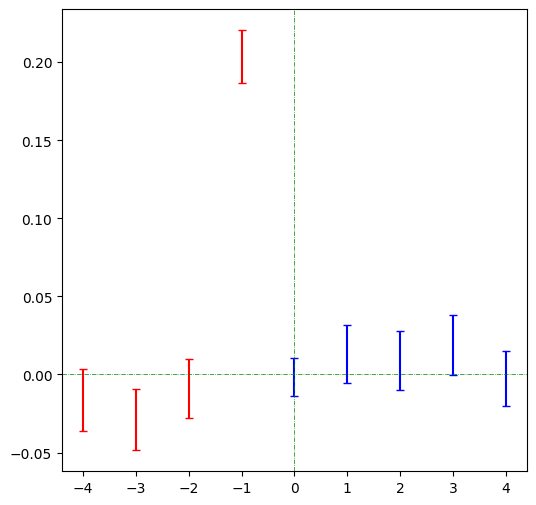

In [15]:
plotFT([dfFT], cosmax=4, sinmax=4)

`FTFMC(df, inverse=True)` will do the inverse FT so you can check the whole procedure for consistency:

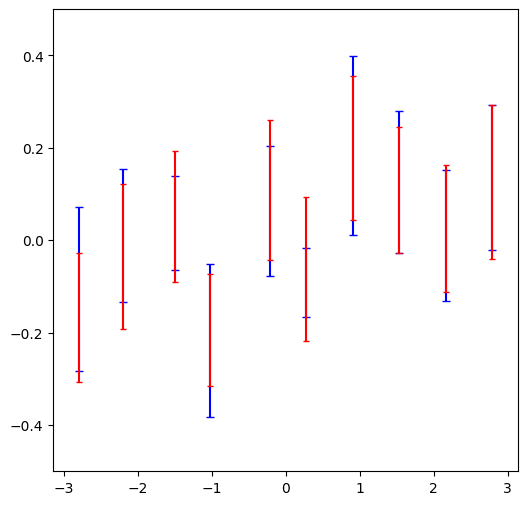

In [16]:
plotpts(binALU[3], g.data.FTFMC(g.data.FTFMC(binALU[3]), inverse=True))

There is also a somewhat experimental function `FTanalyse` that can take a set of bins and determine by cross-validation procedure how many harmonics are "visible" in this data:

In [21]:
cosmax, sinmax = g.data.FTanalyse(binALU)

Highest extractable cos harmonic = 0.684 +- 0.862
Highest extractable sin harmonic = 1.316 +- 0.567



For final harmonic analysis we increase the number of Monte Carlo samples and store the results in two new dataframe columns:

In [22]:
for k in range(len(bins)):
    dfFT = g.data.FTFMC(binALU[k], nsamples = 3000)
    binALU[k]['FTval'] = pd.Series(dfFT['val'].values, index=binALU[k].index)
    binALU[k]['FTerr'] = pd.Series(dfFT['err'].values, index=binALU[k].index)

In [23]:
binALU[4]

,Q2,xB,tm,phi,val,err,errsyst,FTval,FTerr
31,1.97907,0.247267,0.135801,2.809980,0.037401,0.026475,0.01,-0.000498,0.013477
32,1.97907,0.247267,0.135801,2.234021,0.173896,0.029453,0.01,0.010143,0.020810
33,1.97907,0.247267,0.135801,1.588250,0.208313,0.033546,0.01,0.010544,0.018385
34,1.97907,0.247267,0.135801,0.977384,0.164990,0.050159,0.01,0.020095,0.019583
35,1.97907,0.247267,0.135801,0.349066,0.033756,0.059323,0.01,-0.000662,0.018042
36,1.97907,0.247267,0.135801,-0.331613,0.024287,0.060399,0.01,0.205036,0.017117
37,1.97907,0.247267,0.135801,-1.012291,-0.210960,0.048048,0.02,-0.009370,0.019068
38,1.97907,0.247267,0.135801,-1.570796,-0.232754,0.036477,0.01,-0.030501,0.018577
39,1.97907,0.247267,0.135801,-2.234021,-0.155100,0.028140,0.01,-0.019249,0.018672
40,1.97907,0.247267,0.135801,-2.792527,-0.066593,0.029737,0.00,-0.014862,0.012864


In [26]:
def s1(bin):
    """Take just first sine harmonic of bin with error."""
    s1ind = int((len(bin)-1)/2.) + 1 # index of first sine harmonic
    return bin[['Q2', 'xB', 'tm', 'FTval', 'FTerr']].iloc[s1ind]

We unite all bins, taking value and uncertainty of just calculated first sine harmonic (FTval and FTerr), and
we also calculate average and maximal systematic error for given bin. One can than choose which of the two
to take as the proper systematic error of the harmonic (more sophisticated treatment could be implemented here by the person who understands systematics better).


In [30]:
FTs1 = pd.DataFrame([pd.concat([s1(binALU[k]),
                                pd.Series([binALU[k]['errsyst'].mean(),
                                                     binALU[k]['errsyst'].max()], index=['avgsyst', 'maxsyst'])])
                     for k in bins.index]).reset_index(drop=True)

This (after maybe some reduction of significant digits) can now be saved into the new Gepard datafile with appropriate preamble:

In [31]:
FTs1['FTval'] = FTs1['FTval'].map(lambda x: '%.3f' % x)
FTs1['FTerr'] = FTs1['FTerr'].map(lambda x: '%.3f' % x)
FTs1['FTerrsyst'] = FTs1['avgsyst'].map(lambda x: '%.3f' % x)   # choose maxsyst to be conservative

In [33]:
print(FTs1[['Q2', 'xB', 'tm', 'FTval', 'FTerr', 'FTerrsyst']].to_string(index=False))

     Q2       xB       tm FTval FTerr FTerrsyst
1.55354 0.181084 0.128694 0.261 0.042     0.012
1.56422 0.182261 0.230179 0.217 0.373     0.035
1.47020 0.176380 0.475638 0.398 0.448     0.053
1.46031 0.175596 1.081570 0.081 0.067     0.076
1.97907 0.247267 0.135801 0.205 0.017     0.010
2.04773 0.258542 0.227796 0.230 0.021     0.011
1.94335 0.257897 0.457348 0.209 0.030     0.021
1.90114 0.257321 1.194570 0.073 0.032     0.019
2.36222 0.254504 0.137780 0.207 0.027     0.020
2.44750 0.264769 0.228628 0.187 0.030     0.021
2.45794 0.265476 0.443085 0.222 0.038     0.038
2.43020 0.262357 1.141540 0.142 0.287     0.047
2.52890 0.318722 0.157822 0.319 0.228     0.033
2.67020 0.337185 0.240100 0.236 0.026     0.015
2.66546 0.349578 0.455835 0.187 0.020     0.013
2.46831 0.349998 1.191560 0.087 0.024     0.014
3.15132 0.415190 0.271405 1.010 0.598     0.055
3.31407 0.442331 0.506819 0.202 0.040     0.035
3.31725 0.461373 1.159000 0.134 0.030     0.026


Such procedure was followed to create the Gepard datafile ID=94 (some lines are commented out
in that datafile because of various doubts, see comments there):

In [34]:
print(g.dset[94].df()[['Q2', 'xB', 'tm', 'val', 'errstat', 'errsyst']].to_string(index=False))

     Q2       xB       tm   val  errstat  errsyst
1.55354 0.181084 0.128694 0.259    0.042    0.012
1.97907 0.247267 0.135801 0.205    0.017    0.010
2.04773 0.258542 0.227796 0.231    0.022    0.011
1.94335 0.257897 0.457348 0.210    0.030    0.021
2.36222 0.254504 0.137780 0.206    0.027    0.020
2.44750 0.264769 0.228628 0.187    0.031    0.021
2.45794 0.265476 0.443085 0.223    0.038    0.038
2.67020 0.337185 0.240100 0.236    0.026    0.015
2.66546 0.349578 0.455835 0.187    0.021    0.013
3.31407 0.442331 0.506819 0.204    0.041    0.035


# Extraction of weighted harmonics (HALL A $X_{\rm UU}$)

For total cross-section, it is convenient to work with "weighted" harmonics, where weights are proportional to normalized inverse Bethe-Heitler propagators. See e.g. 1602.02763. Sect 2.2.

In [27]:
Sdata = g.dset[129]+g.dset[130]+g.dset[131]+g.dset[132]+g.dset[133]+g.dset[134]

In [28]:
g.describe_data(Sdata)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
36 x XUU     HALLA   N/A    129 arXiv:1703.09442
36 x XUU     HALLA   N/A    130 arXiv:1703.09442
96 x XUU     HALLA   N/A    131 arXiv:1703.09442
96 x XUU     HALLA   N/A    132 arXiv:1703.09442
96 x XUU     HALLA   N/A    133 arXiv:1703.09442
90 x XUU     HALLA   N/A    134 arXiv:1703.09442
----------------------------------------------
TOTAL = 450


In [29]:
# This precalculates needed propagators among other things
for pt in Sdata:
    pt.prepare()

In [30]:
# Store normalized BH propagator weights
Swghs = [g.weight_BH(pt) for pt in Sdata]

We shall MC-propagate statistical and point-to-point asymmetric systematic error (made symmetric by taking max(err+,err-) added in quadrature. Normalization error is just added to obtained harmonics.

When datafiles are loaded, `err` , besides statistical, contains both point-to-point and normalization systematic errors, so we have to subtract normalization error before FT:
$$\Delta_{\rm point-to-point} =  \sqrt{\Delta^2 - \Delta_{\rm norm}^2}$$

In [31]:
# weighted data, NOTE err = everything apart from normalization err !
dfS = pd.DataFrame([(pt.in1energy, pt.Q2, pt.xB, pt.tm, pt.phi, w*pt.val, w*np.sqrt(pt.err**2-pt.errnorm**2))
                    for pt, w in zip(Sdata, Swghs)], columns=('E', 'Q2', 'xB', 'tm', 'phi', 'val', 'err')) 

In [32]:
all_Sbins = dfS[['E', 'Q2', 'xB', 'tm']].drop_duplicates()
Sbins = all_Sbins.reset_index(drop=True)
print("We have {} X_UU bins.".format(len(Sbins)))

We have 22 X_UU bins.


In [33]:
binS = {}
for k in Sbins.index:
    # binS[k] = dfS[dfS[['E', 'Q2', 'xB', 'tm']].values == Sbins.iloc[k].values].drop_duplicates()
    binS[k] = dfS[np.all(dfS[['E', 'Q2', 'xB', 'tm']] == Sbins.iloc[k], axis=1)]

In [34]:
nc, ns = g.data.FTanalyse(binS)

Highest extractable cos harmonic = 1.409 +- 0.492
Highest extractable sin harmonic = 0.955 +- 0.928



So zeroth and first cosine harmonics are clean. One could argue for second in some bins or first sine? Still we go with simplest model: just zeroth and first cosine:

In [35]:
nc = 1; ns = 0;

## Simple treatment

In [36]:
for k in Sbins.index:
    bn = binS[k]
    dfFT = g.data.FTFMC(bn, nsamples = 3000, cosmax=nc, sinmax=ns)
    for typ in ('val', 'err'):
        bn.insert(len(bn.columns), 'FT'+typ, pd.Series(dfFT[typ].values, index=bn.index))

In [37]:
def c0(bin):
    """Zeroth cosine harmonic of bin with total stat error.""" 
    return bin[['E', 'Q2', 'xB', 'tm', 'FTval', 'FTerr']].iloc[0] 
def c1(bin):
    return bin[['E', 'Q2', 'xB', 'tm', 'FTval', 'FTerr']].iloc[1]

In [38]:
FTc0 = pd.DataFrame([c0(binS[k]) for k in Sbins.index]).reset_index(drop=True)
FTc0['FTn'] = 0
FTc1 = pd.DataFrame([c1(binS[k]) for k in Sbins.index]).reset_index(drop=True)
FTc1['FTn'] = 1

In [39]:
#print(FTc0[['E', 'Q2', 'xB', 'tm', 'FTn', 'FTval', 'FTerr']].to_string(index=False))
print(FTc1[['E', 'Q2', 'xB', 'tm', 'FTn', 'FTval', 'FTerr']].to_string(index=False))

    E   Q2    xB    tm  FTn     FTval    FTerr
5.550 1.51 0.359 0.180    1  0.026576 0.002191
5.550 1.51 0.359 0.237    1  0.042592 0.002849
5.550 1.52 0.361 0.298    1  0.050190 0.004200
3.355 1.49 0.357 0.177    1  0.014822 0.005342
3.355 1.50 0.359 0.236    1  0.039577 0.005607
3.355 1.50 0.360 0.296    1  0.042872 0.010346
5.550 1.74 0.359 0.183    1  0.009694 0.000775
5.550 1.74 0.359 0.242    1  0.020988 0.000928
5.550 1.74 0.359 0.302    1  0.029884 0.001118
5.550 1.75 0.361 0.363    1  0.036283 0.001405
4.455 1.74 0.357 0.181    1  0.006169 0.001504
4.455 1.74 0.357 0.240    1  0.015017 0.001571
4.455 1.74 0.358 0.301    1  0.024125 0.001767
4.455 1.76 0.361 0.363    1  0.028225 0.001869
5.550 1.98 0.357 0.182    1  0.001579 0.001016
5.550 1.98 0.356 0.242    1  0.011594 0.001079
5.550 1.98 0.356 0.302    1  0.012876 0.001191
5.550 1.99 0.358 0.363    1  0.013565 0.001253
4.455 1.98 0.356 0.182    1 -0.000087 0.001899
4.455 1.99 0.357 0.242    1  0.006223 0.001890
4.455 2.00 0.

Result of similar analysis can be found in Gepard's datafile ID=137:

In [40]:
for pt in g.dset[137]:
    if pt.FTn == 1:
        print("{:6.3} {:6.3} {:6.3} {:6.3}   {:8.5f} {:8.5f} ".format(pt.in1energy, pt.Q2, pt.xB, pt.tm, pt.val, pt.errstat))

  5.55   1.51  0.359   0.18    0.02646  0.00220 
  5.55   1.51  0.359  0.237    0.04249  0.00282 
  5.55   1.52  0.361  0.298    0.05023  0.00422 
  3.35   1.49  0.357  0.177    0.01479  0.00531 
  3.35    1.5  0.359  0.236    0.03948  0.00544 
  3.35    1.5   0.36  0.296    0.04285  0.01039 
  5.55   1.74  0.359  0.183    0.00970  0.00080 
  5.55   1.74  0.359  0.242    0.02102  0.00093 
  5.55   1.74  0.359  0.302    0.02988  0.00113 
  5.55   1.75  0.361  0.363    0.03621  0.00140 
  4.46   1.74  0.357  0.181    0.00624  0.00150 
  4.46   1.74  0.357   0.24    0.01509  0.00159 
  4.46   1.74  0.358  0.301    0.02418  0.00171 
  4.46   1.76  0.361  0.363    0.02827  0.00190 
  5.55   1.98  0.357  0.182    0.00155  0.00103 
  5.55   1.98  0.356  0.242    0.01151  0.00110 
  5.55   1.98  0.356  0.302    0.01289  0.00120 
  5.55   1.99  0.358  0.363    0.01355  0.00127 
  4.46   1.98  0.356  0.182   -0.00019  0.00201 
  4.46   1.99  0.357  0.242    0.00622  0.00188 
  4.46    2.0   0.36

## Treatment with cos-phi uncertainty enhancement

Using now the $c_0/c_1$ correction for $\phi$-modulated correlated systematic errors in a worst case scenario. See e.g. 1602.02763 Sect 3.1.

Hall A: _"... the systematic
uncertainty associated to the exclusivity cut estimated
to be **2%**. [...] A **2%**-systematic uncertainty has been attributed to the radiative
corrections and a **1%**-uncertainty to the HRS
acceptance model [24]. The simulation is used to account
for bin migration effects due to detector resolution
and Bremsstrahlung radiation, with **1%** systematic uncertainty.
An additional bin in t is used to correct for
bin migration in and out of the largest abs(t)-bin. We also
include **2%** uncertainty for the integrated luminosity and
data acquisition dead-time correction and **0.5%** for trigger
efficiency, which yields a total systematic uncertainty
of 3.7% for the unpolarized cross sections"_

In [41]:
np.sqrt(np.sum([err**2 for err in [2, 2, 1, 1, 2, 0.5]]))

np.float64(3.774917217635375)

We will assume that exclusivity cut and radiative corrections can be sources of $\phi$-modulated syst error, susceptible to c0/c1 enhancement:

In [42]:
def c0(bin):
    """Zeroth cosine harmonic of bin with total error."""
    # correlated syst error in %
    corrD = np.sqrt(np.sum([err**2 for err in [2, 2, 1, 
                                                1, 2, 0.5]]))
    # correlated syts error
    syst = abs(bin['FTval'].iloc[0] * corrD * 0.01)
    aux = bin[['E', 'Q2', 'xB', 'tm', 'FTval', 'FTerr']].iloc[0]   
    return pd.concat([aux, pd.Series([syst], index=['syst'])])
def c1(bin, enh=1.):
    """First cosine harmonic of bin with total error.
    
    enh - enhancement of phi-modulated sources of syst err
    """
    corrD = np.sqrt(np.sum([err**2 for err in [enh*2, enh*2, 1, 
                                               1, 2, 0.5]]))
    # correlated syts error
    syst = abs(bin['FTval'].iloc[1] * corrD * 0.01)
    aux = bin[['E', 'Q2', 'xB', 'tm', 'FTval', 'FTerr']].iloc[1]   
    return pd.concat([aux, pd.Series([syst], index=['syst'])])

First get just mean values for calculation of enhancement ratios

In [43]:
FTc0 = pd.DataFrame([c0(binS[k]) for k in Sbins.index]).reset_index(drop=True)
FTc0['FTn'] = 0
FTc1 = pd.DataFrame([c1(binS[k], enh=1.) for k in Sbins.index]).reset_index(drop=True)

In [44]:
# enhancement ratios by bins
c0overc1 = FTc0['FTval'].values / FTc1['FTval'].values; c0overc1

array([ 3.36640528e+00,  1.87999507e+00,  1.33986614e+00,  1.52479929e+01,
        4.24211958e+00,  2.96859981e+00,  6.63760189e+00,  2.62139170e+00,
        1.65305933e+00,  1.24433972e+00,  1.71553736e+01,  5.38152845e+00,
        2.62753607e+00,  1.80354417e+00,  3.84551639e+01,  4.12921340e+00,
        2.87720993e+00,  2.23398184e+00, -1.25524232e+03,  1.29776865e+01,
        4.14703171e+00,  2.91979042e+00])

And now corrected $c_1$ including enhancement ratios

In [45]:
FTc1 = pd.DataFrame([c1(binS[k], enh=c0overc1[k]) for k in Sbins.index]).reset_index(drop=True)
FTc1['FTn'] = 1

In [46]:
print(FTc1)

        E    Q2     xB     tm     FTval     FTerr      syst  FTn
0   5.550  1.51  0.359  0.180  0.026576  0.002191  0.002616    1
1   5.550  1.51  0.359  0.237  0.042592  0.002849  0.002503    1
2   5.550  1.52  0.361  0.298  0.050190  0.004200  0.002279    1
3   3.355  1.49  0.357  0.177  0.014822  0.005342  0.006403    1
4   3.355  1.50  0.359  0.236  0.039577  0.005607  0.004851    1
5   3.355  1.50  0.360  0.296  0.042872  0.010346  0.003756    1
6   5.550  1.74  0.359  0.183  0.009694  0.000775  0.001836    1
7   5.550  1.74  0.359  0.242  0.020988  0.000928  0.001642    1
8   5.550  1.74  0.359  0.302  0.029884  0.001118  0.001584    1
9   5.550  1.75  0.361  0.363  0.036283  0.001405  0.001566    1
10  4.455  1.74  0.357  0.181  0.006169  0.001504  0.002997    1
11  4.455  1.74  0.357  0.240  0.015017  0.001571  0.002316    1
12  4.455  1.74  0.358  0.301  0.024125  0.001767  0.001892    1
13  4.455  1.76  0.361  0.363  0.028225  0.001869  0.001603    1
14  5.550  1.98  0.357  0

Result of similar analysis can be found in Gepard's datafile ID=136:

In [47]:
for pt in g.dset[136]:
    if pt.FTn == 1:
        print("{:6.3} {:6.3} {:6.3} {:6.3}   {:8.5f} {:8.5f} {:8.5f}".format(pt.in1energy, pt.Q2, pt.xB, pt.tm, pt.val, pt.errstat, pt.errsyst))

  5.55   1.51  0.359   0.18    0.02655  0.00213  0.00262
  5.55   1.51  0.359  0.237    0.04248  0.00283  0.00250
  5.55   1.52  0.361  0.298    0.05030  0.00414  0.00228
  3.35   1.49  0.357  0.177    0.01497  0.00539  0.00641
  3.35    1.5  0.359  0.236    0.03961  0.00556  0.00485
  3.35    1.5   0.36  0.296    0.04240  0.01026  0.00376
  5.55   1.74  0.359  0.183    0.00970  0.00079  0.00184
  5.55   1.74  0.359  0.242    0.02105  0.00095  0.00164
  5.55   1.74  0.359  0.302    0.02990  0.00112  0.00159
  5.55   1.75  0.361  0.363    0.03626  0.00141  0.00157
  4.46   1.74  0.357  0.181    0.00611  0.00151  0.00300
  4.46   1.74  0.357   0.24    0.01505  0.00156  0.00232
  4.46   1.74  0.358  0.301    0.02417  0.00171  0.00189
  4.46   1.76  0.361  0.363    0.02824  0.00191  0.00160
  5.55   1.98  0.357  0.182    0.00159  0.00102  0.00172
  5.55   1.98  0.356  0.242    0.01158  0.00110  0.00138
  5.55   1.98  0.356  0.302    0.01282  0.00119  0.00110
  5.55   1.99  0.358  0.363    